In [1]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.misc.productivity import faculty_at_institution
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from scipy.special import gamma as gammaf
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.cross_validation import StratifiedKFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from collections import Counter, defaultdict
from scipy import interp
import statsmodels.api as sm
import numpy as np
import math
import scipy as sp
import pandas as pd
import os
import mpld3
import palettable

sig_level = 0.05

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Code/src/github.com/allisonmorgan/faculty_hiring/notebooks-productivity/figures/'
#nces_table = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/nces_table.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst)
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']

load.load_all_publications(asst_faculty, dblp_dir)

In [3]:
valid_titles = ['Assistant Professor', 'Associate Professor', 'Full Professor']

In [4]:
followup_data = '/Users/allisonmorgan/Code/src/github.com/allisonmorgan/faculty_hiring/notebooks-productivity/Finalized_Spreadsheet_Nov21.tsv'

def load_followup_data(faculty, followup_file):
    """ Loads the follow-up spreadsheet data collected by BuffTurkers in Nov2016 """
    df = pd.read_csv(followup_file, sep='\t')
    profiles_updated = 0
    
    for person in faculty:
        # When collection assignements are created, these fields are written out:
        # person.facultyName, person.place, person.current
        num_records = len(df[df['Faculty name'] == person.facultyName])
        if num_records == 0: # No matches, this is fine
            continue  
        elif num_records == 1: # One match, this is great
            row = df[df['Faculty name'] == person.facultyName]
            if row['Institution (2011)'].iloc[0] != person.place:
                continue
            person['followup_title'] = row['Job Title (2016)'].iloc[0]
            person['followup_location'] = row['Institution (2016)'].iloc[0]
            person['followup_department'] = row['Department (2016)'].iloc[0]
            profiles_updated += 1
        else: # Multiple matches, this... is bad. Blow up.
            raise ValueError('Multiple records detected!')
            
    assert (profiles_updated <= len(df))
    print 'Updated %d profiles!' % (profiles_updated)

load_followup_data(asst_faculty, followup_data)

Updated 555 profiles!


## Compare with Publications

In [5]:
trajectories_position = Counter()
trajectories_location = Counter()
trajectories_moved_and_left = Counter()
for person in asst_faculty:
    if 'followup_title' in person and 'current' in person:
        key = "%s -> %s" % (person['current'], person['followup_title'])
        trajectories_position[key] += 1
        
        key = "%s" % ("STAYED" if person['followup_location'] == person['place'] else "MOVED")
        trajectories_location[key] += 1
        
        if person['followup_location'] != person['place']:
            key = "%s" % ("LEFT ACADEMIA" if person['followup_location'] == "NOT IN ACADEMIA" else "STAYED IN ACADEMIA")
            trajectories_moved_and_left[key] += 1
        
print trajectories_position
print trajectories_location
print trajectories_moved_and_left

Counter({'Assistant Professor -> Associate Professor': 366, 'Assistant Professor -> Assistant Professor': 104, 'Assistant Professor -> NOT TT': 68, 'Assistant Professor -> Full Professor': 17})
Counter({'STAYED': 404, 'MOVED': 151})
Counter({'STAYED IN ACADEMIA': 78, 'LEFT ACADEMIA': 73})


In [6]:
78/(151)

0.5165562913907285

In [7]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
# Set limit_by_years_post_hire flag to True to consider only the contributions within the first 5 
# years of a researcher's career.
limit_by_years_post_hire = True
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']
pubs_by_inst = {}
pubs_by_year_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []; n_pubs_by_year = [];
    for person in current_faculty:
        start = person.first_asst_job_year
        if limit_by_years_post_hire:
            end = np.min([2012, person.first_asst_job_year + 5])
        else:
            end = 2012
        career_length = end - start
        
        if person.__contains__('dblp_pubs'):
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub \
                      and pub['year'] >= start \
                      and pub['year'] < end \
                      and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            
            n_pubs.append((person.facultyName, contribution))
            n_pubs_by_year.append((person.facultyName, contribution/float(career_length)))
    if len(n_pubs) > 0:
        pubs_by_inst[name] = n_pubs
        pubs_by_year_by_inst[name] = n_pubs_by_year

In [8]:
# Compare the average publication rate of a person in their first five years, 
# to the average publication rate of faculty within their first five years at
# both the institution they came from and went to
publication_trajectories = []
for person in asst_faculty:
    if 'followup_title' in person and person.__contains__('dblp_pubs'):
        initial_institution = person.current_job()[0]
        final_institution = person['followup_location']
        
        # Get average publication rate of the young faculty at either institution
        if initial_institution == final_institution:
            # Don't consider those people who took promotions at the same institution.
            continue
        # This will skip anyone who left academia (i.e. their final_institution == "NOT TT")
        if pubs_by_year_by_inst.has_key(initial_institution) and pubs_by_year_by_inst.has_key(final_institution):
            # TODO: remove people with count == 0. Those people have zero pubs to their name. This shouldn't happen right?
            initial_counts = [count for (_, count) in pubs_by_year_by_inst[initial_institution] if count > 0]
            initial_pub_rate = np.mean([np.log(count) for count in initial_counts])
            initial_pub_std = np.std([np.log(count) for count in initial_counts])
            
            final_counts = [count for (_, count) in pubs_by_year_by_inst[final_institution] if count > 0]
            final_pub_rate = np.mean([np.log(count) for count in final_counts])
            final_pub_std = np.std([np.log(count) for count in final_counts])
            
            # Get this person's publication rate
            start = person.current_job()[1]
            end = np.min([2012, start + 5])
            career_length = end - start
        
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub \
                      and pub['year'] >= start \
                      and pub['year'] < end \
                      and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            personal_pub_rate = (contribution/float(career_length))
            
            publication_trajectories.append((
                    (np.log(personal_pub_rate), inst[initial_institution]['pi'], inst[final_institution]['pi']), 
                    (initial_pub_rate, initial_pub_std), 
                    (final_pub_rate, final_pub_std)
                ))

In [9]:
print("Number of faculty who changed universities (but stayed in academia)", len(publication_trajectories))
personal_pub_rates = [r for ((r, _, _) , _, _ ) in publication_trajectories]
print("Median personal publication rate", np.exp(np.median(personal_pub_rates)))

('Number of faculty who changed universities (but stayed in academia)', 78)
('Median personal publication rate', 3.7121406784047739)


In [10]:
# How many times was the final institution a better fit?
final_moved_up = 0; num_people_moved_up = 0;
final_moved_down = 0; num_people_moved_down = 0;
final_vs_delta_rank = defaultdict(list)
#diffs_mu = []; diffs_sigma = [];
# Everything has alreday been log-ed above ^
for ((personal, initial_rank, final_rank), (initial_mu, initial_sigma), (final_mu, final_sigma)) in publication_trajectories:
    likelihood_of_final = sp.stats.norm.pdf(personal, final_mu, final_sigma)
    likelihood_of_initial = sp.stats.norm.pdf(personal, initial_mu, initial_sigma)
    
    #diffs_mu.append(initial_mu - final_mu)
    #diffs_sigma.append(initial_sigma - final_sigma)
    
    # Did the person make a decrease in rank? Or did they move up?
    delta_rank = (final_rank - initial_rank)
    similar_to_final = (likelihood_of_final > likelihood_of_initial)
    if delta_rank > 0:
        if similar_to_final:
            final_moved_up += 1
        num_people_moved_up += 1
    else: 
        if similar_to_final:
            final_moved_down += 1
        num_people_moved_down += 1
    
    final_vs_delta_rank[delta_rank].append(similar_to_final)

In [11]:
print(min(final_vs_delta_rank.keys()), max(final_vs_delta_rank.keys()))

(-142.01, 125.67999999999999)


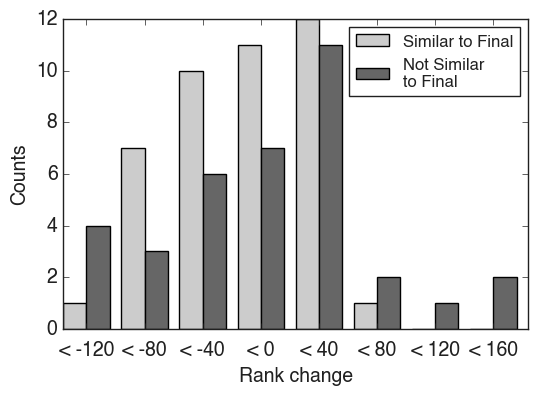

In [12]:
N = 5*2-1
bins = 40
width = 0.4
ind = [(-i) for i in sorted(range(5), reverse=True)]
ind.extend([i for i in range(5) if i > 0])
ind = np.array(ind)

i = 0
similar_to_final = np.zeros(N); not_similar_to_final = np.zeros(N)
for delta_rank in sorted(final_vs_delta_rank.keys()):
    if delta_rank >= bins*((i-4) + 1):
        i += 1
    #print(delta_rank, bins*((i-4) + 1), final_vs_delta_rank[delta_rank])
    for x in final_vs_delta_rank[delta_rank]:
        if x:
            similar_to_final[i] += 1
        else:
            not_similar_to_final[i] += 1
    #print(similar_to_final)

fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
rects1 = ax.bar(ind[:(len(ind)-1)], similar_to_final[:(len(ind)-1)], width, color=LIGHT_COLOR_V)
rects2 = ax.bar(ind[:(len(ind)-1)] + width, not_similar_to_final[:(len(ind)-1)], width, color=DARK_COLOR_V)
ax.legend((rects1[0], rects2[0]), ('Similar to Final', 'Not Similar \nto Final'), fontsize=LABEL_SIZE-2)
ax.set_xticks(ind[:(len(ind)-1)] + width)
#ax.set_xticklabels(('-160', '-120', '-80', '-40', '0', '40', '80', '120', '160'))
ax.set_xticklabels(('< -120', '< -80', '< -40', '< 0', '< 40', '< 80', '< 120', '< 160'), fontsize=LABEL_SIZE)
ax.set_yticklabels(('0', '2', '4', '6', '8', '10', '12', '14'), fontsize=LABEL_SIZE)
ax.set_ylim(0, 12)
ax.set_ylabel("Counts", fontsize=LABEL_SIZE)
ax.set_xlabel("Rank change", fontsize=LABEL_SIZE)
plt.show()

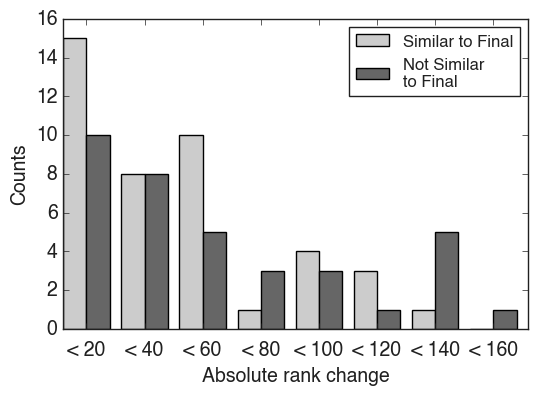

In [13]:
N = 8
bins = 20
width = 0.4
ind = np.array(range(N))
i = 0

abs_ranks = sorted(np.unique([abs(key) for key in final_vs_delta_rank.keys()]))
similar_to_final = np.zeros(N); not_similar_to_final = np.zeros(N)
for delta_rank in abs_ranks:
    if delta_rank >= bins*(i + 1):
        i += 1
    
    for x in final_vs_delta_rank[delta_rank]:
        if x:
            similar_to_final[i] += 1
        else:
            not_similar_to_final[i] += 1
    for x in final_vs_delta_rank[-(delta_rank)]:
        if x:
            similar_to_final[i] += 1
        else:
            not_similar_to_final[i] += 1
    
fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
rects1 = ax.bar(ind, similar_to_final, width, color=LIGHT_COLOR_V)
rects2 = ax.bar(ind + width, not_similar_to_final, width, color=DARK_COLOR_V)
ax.legend((rects1[0], rects2[0]), ('Similar to Final', 'Not Similar \nto Final'), fontsize=LABEL_SIZE-2)
ax.set_xticks(ind + width)
ax.set_xticklabels(('< 20', '< 40', '< 60', '< 80', '< 100', '< 120', '< 140', '< 160'), fontsize=LABEL_SIZE)
ax.set_yticklabels(('0', '2', '4', '6', '8', '10', '12', '14', '16'), fontsize=LABEL_SIZE)
ax.set_ylabel("Counts", fontsize=LABEL_SIZE)
ax.set_xlabel("Absolute rank change", fontsize=LABEL_SIZE)
plt.show()

In [14]:
"How many people moved up? {0} How many moved down? {1}".format(num_people_moved_up, num_people_moved_down)

'How many people moved up? 29 How many moved down? 49'

In [15]:
(final_moved_up/num_people_moved_up, final_moved_down/num_people_moved_down)

(0.4482758620689655, 0.5918367346938775)

In [16]:
#fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
#plt.hist(diffs_mu)
#plt.show()

In [17]:
#fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
#plt.hist(diffs_sigma, bins=100)
#plt.show()

In [18]:
#fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
#plt.hist(personal_pub_rates, bins=100)
#plt.show()
personal_pub_rates

[1.6396625330885706,
 1.2892091802387979,
 2.2211947714767684,
 0.42522482990773169,
 1.0874206336753007,
 1.3845323385632315,
 1.225719410598187,
 -inf,
 0.96682308876222189,
 1.3637843789846686,
 1.3637843789846686,
 1.7946945025396219,
 1.3197014314959026,
 1.3580292122873749,
 1.3751104169211692,
 1.317880237164986,
 -1.3396947845222007,
 -1.4885957076313856,
 -0.13934598244340995,
 1.3092010409400381,
 1.600634136900188,
 1.0761023065328879,
 0.9753794302272647,
 1.7934555258575611,
 1.7786903001665217,
 1.2399622316458048,
 -inf,
 1.5786688593958711,
 1.4719365828956037,
 0.37369580968843669,
 0.68977743891217058,
 0.36337718196622171,
 1.7019232714279426,
 0.34671036530397531,
 -inf,
 1.6714501924797234,
 1.7362749961134778,
 1.7255166486288578,
 1.3751682490776604,
 1.9032331384584558,
 1.5016011642411866,
 1.769249487092833,
 0.051944533179139614,
 0.79777456758982823,
 1.5035512834017366,
 -inf,
 0.30500287714362628,
 1.3140163840259236,
 1.0874206336753007,
 0.49117563501274